In [1]:
img_url = 'https://www.soyuz.ru/public/uploads/files/2/7393973/201910191417186948f5f1b7.jpg'
video_url = 'https://www.youtube.com/watch?v=sHzdsFiBbFc'

## ДЗ №1

1. Поместить в центр рисунка белый квадрат, занимающий 10% площади рисунка.

Изначальная картинка (555x1000)


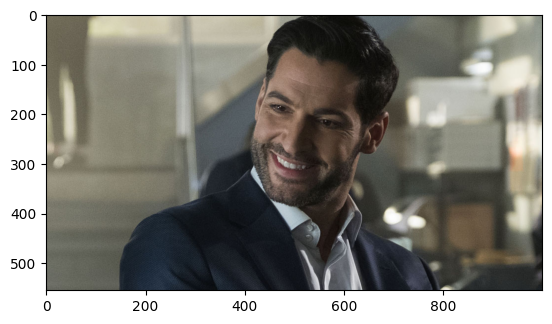

Новая картинка


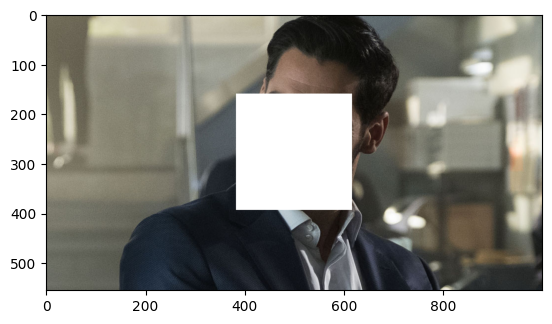

In [3]:

from urllib.request import urlopen

import matplotlib.pyplot as plt

orig_img = plt.imread(urlopen(img_url), format='jpg')
print(f'Изначальная картинка ({orig_img.shape[0]}x{orig_img.shape[1]})')
plt.imshow(orig_img)
plt.show()

print('Новая картинка')
new_img = orig_img.copy()
center = [i // 2 for i in new_img.shape[:-1]]
size = center[0] * center[1] * 4
half_a = int((size * 0.1) ** 0.5) // 2
new_img[center[0] - half_a: center[0] + half_a, center[1] - half_a: center[1] + half_a, :] = 255
plt.imshow(new_img)
plt.show()


## ДЗ №2

1. Поместить в в случайном месте каждого кадра видеопотока белый кварат со стороной 50 px.

In [ ]:

import cv2, pafy
import random

video = pafy.new(video_url, basic=False)
best = video.getbest()
print("BEST QUALITY -", best)

filepath = '1c3e7c11-1e09-4915-ad4a-1d7b57733c5b.mp4'
print("DOWNLOADING...")
filename = best.download(filepath=filepath, quiet=False)
print('DONE DOWNLOADING...')

print('STARTING PLAYER...')
capture = cv2.VideoCapture(filepath)
capture.set(cv2.CAP_PROP_FPS, 10)

while True:
    rtrn, image = capture.read()
    if not rtrn:
        break
    width, height = image.shape[:2]
    x, y = random.randint(0, width - 50), random.randint(0, height - 50)
    image[x: x + 50, y: y + 50, :] = [255] * 3

    cv2.imshow("OpenCV", image)

    if cv2.waitKey(1000 // 30) == ord('q'):
        print('QUITING...')
        break

print('VIDEO PLAYED...')

capture.release()
cv2.destroyAllWindows()

## ДЗ №3

1. Найти в обучающем наборе esc50-dataset WAV файл с лаем собаки;
2. визуально по графику амплитуды звуковой волны найти участок файла непосредственно содержащий звук лая;
3. построить спектрограмму для найденного участка;
4. подумать (и реализовать), как с помощиью цифрового представления звука можно автоматизировать удаление части файла, не содержащего полезной информации.

In [ ]:
!pip install librosa

In [ ]:
import numpy as np
import soundfile as sf
import io
from six.moves.urllib.request import urlopen

audio_data = 'https://raw.githubusercontent.com/karolpiczak/ESC-50/master/audio/1-32318-A-0.wav'

data, sample_rate = sf.read(io.BytesIO(urlopen(audio_data).read()))


In [ ]:
import IPython.display as ipd

ipd.Audio(audio_data)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))

amplitude = data.max() - data.min()
average = np.average(np.absolute(data))
treshold = np.sqrt(np.std(data)) / 4
skip = 10
delta = int(0.05 * sample_rate)
print(treshold)
gt_than_std = np.where(data > treshold)

librosa.display.waveshow(data, sr=sample_rate)
plt.axhline(treshold, c='y')
prev = None
left = None
right = None
for e in gt_than_std[0]:
    if prev is None:
        left = e
        plt.axvline(e / sample_rate, c='r')
    elif e - prev > 1000:
        if right is None:
            right = prev
        plt.axvline(prev / sample_rate, c='r')
        plt.axvline(e / sample_rate, c='r')

    prev = e

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(6, 3))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
meaningful_data = data[left:right]
X = librosa.stft(meaningful_data)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(6, 3))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

## ДЗ №4

1. Выбрать любой казанский автобусный маршрут;
2. проследить с помощью API сайта data.kzn.ru за автобусом выбранного маршрута достаточное количество времени, чтобы сформировать представление о всём пути следования автобуса;
3. изобразить маршрут на карте;
4. подумайте, как найти правильный центр рисунка;
5. подумайте как найти и указать на рисунке остановки выбранного маршрута.

In [3]:
from datetime import datetime, timedelta
from time import sleep
import httpx
import json

url = 'https://navi.kazantransport.ru/api/rpc.php'
client = httpx.Client()

print("Creating new https://navi.kazantransport.ru/ session...")
response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "startSession",
        "params": {},
        "id": 1
    }
)
if response.status_code != 200:
    raise ValueError(f"Something went wrong...[session] {response.status_code}")

session = response.json()
sid = session['result']['sid']
print(f"Session ID: {sid}")

print("Collecting bus data...")

response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "getTransTypeTree",
        "params": {
            "sid": sid,
            "ok_id": ""
        },
        "id": 2
    }
)
if response.status_code != 200:
    raise ValueError(f"Something went wrong...[transports] {session.status_code}")

transports = response.json()
# print(json.dumps(transports, indent=4, ensure_ascii=False))

mr_id = "11"

print(f"Collecting data for mr_id={mr_id}...")

response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "getUnits",
        "params": {
            "sid": sid,
            "marshList": [
                mr_id
            ]
        },
        "id": 3
    }
)

if response.status_code != 200:
    raise ValueError(f"Something went wrong...[units] {session.status_code}")

units = response.json()
# print(json.dumps(units, indent=4, ensure_ascii=False))
u_id = "1-8435367"

data = []

now = datetime.now()
delta = timedelta(hours=2)
while (n := datetime.now()) - delta < now:
    print(f"Collecting... [{n}]")
    response = client.post(
        url=url,
        json={
            "jsonrpc": "2.0",
            "method": "getUnits",
            "params": {
                "sid": sid,
                "marshList": [
                    mr_id
                ]
            },
            "id": 3
        }
    )
    units = response.json()
    bus = next(filter(lambda s: s['u_id'] == u_id, units['result']))
    data.append([bus['u_lat'], bus['u_long'], bus['u_speed']])
    sleep(20)

Creating new https://navi.kazantransport.ru/ session...
Session ID: 32DB5B2B-F86A-4EBE-9E95-76C58FB1B855
Collecting... [2022-10-23 18:48:17.787313]
Collecting... [2022-10-23 18:48:37.979063]
Collecting... [2022-10-23 18:48:58.295064]
Collecting... [2022-10-23 18:49:18.613224]
Collecting... [2022-10-23 18:49:39.019099]
Collecting... [2022-10-23 18:49:59.331056]
Collecting... [2022-10-23 18:50:19.679057]
Collecting... [2022-10-23 18:50:40.023248]
Collecting... [2022-10-23 18:51:00.339273]
Collecting... [2022-10-23 18:51:20.699061]
Collecting... [2022-10-23 18:51:40.995072]
Collecting... [2022-10-23 18:52:01.307060]
Collecting... [2022-10-23 18:52:21.635065]
Collecting... [2022-10-23 18:52:41.951041]
Collecting... [2022-10-23 18:53:02.239166]
Collecting... [2022-10-23 18:53:22.563185]
Collecting... [2022-10-23 18:53:42.979935]
Collecting... [2022-10-23 18:54:03.321436]
Collecting... [2022-10-23 18:54:23.932114]
Collecting... [2022-10-23 18:54:44.271219]
Collecting... [2022-10-23 18:55:04.

In [5]:
with open("bus.json", "w", encoding="utf8") as f:
    f.write(json.dumps(data, ensure_ascii=False))

In [ ]:
import json

import httpx

print("Перейдите по ссылке:")
print(
    "https://oauth.vk.com/authorize?client_id=51456500&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=offline&response_type=token&v=5.131")
token = "vk1.a.3k65vcLSbhuWW99x9xjGS9l67vmvU0pMERzJQ9tCkJW_hY1NFDOGWZxhlzZd_Uq4WWfzGm4nCnDfk0VxF_D4ucRxmB_YDaWUcfJAD7LtIheUtH38hQ4wXFfAEMn3xgRa4k1nzT2yXX9kXOJXhuSZmWKJoreDq9cD8llUtt1vWpamSkeA9jID1pg7dYPWT6BuPbvn3NttsLcJYv6kPhc3pA"

client = httpx.Client(base_url="https://api.vk.com/method/")
posts = []
offset = 0
while len(posts) < 2000:
    print(len(posts))
    response = client.get(
        url='wall.get',
        params={
            "access_token": 'vk1.a.3k65vcLSbhuWW99x9xjGS9l67vmvU0pMERzJQ9tCkJW_hY1NFDOGWZxhlzZd_Uq4WWfzGm4nCnDfk0VxF_D4ucRxmB_YDaWUcfJAD7LtIheUtH38hQ4wXFfAEMn3xgRa4k1nzT2yXX9kXOJXhuSZmWKJoreDq9cD8llUtt1vWpamSkeA9jID1pg7dYPWT6BuPbvn3NttsLcJYv6kPhc3pA',
            "owner_id": "-23956131",
            "v": "5.131",
            "offset": offset,
            "count": 100
        }
    ).json()
    for post in response['response']['items']:
        if post['text'] != '':
            posts.append(post)
    offset += 100

with open("posts.json", "w", encoding="utf8") as f:
    f.write(json.dumps(posts, ensure_ascii=False))

## ДЗ №4

1. Выбрать любой казанский автобусный маршрут;
2. проследить с помощью API сайта data.kzn.ru за автобусом выбранного маршрута достаточное количество времени, чтобы сформировать представление о всём пути следования автобуса;
3. изобразить маршрут на карте;
4. подумайте, как найти правильный центр рисунка;
5. подумайте как найти и указать на рисунке остановки выбранного маршрута.

In [85]:
from datetime import datetime, timedelta
from time import sleep
import httpx
import json

url = 'https://navi.kazantransport.ru/api/rpc.php'
client = httpx.Client()

print("Creating new https://navi.kazantransport.ru/ session...")
response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "startSession",
        "params": {},
        "id": 1
    }
)
if response.status_code != 200:
    raise ValueError(f"Something went wrong...[session] {response.status_code}")

session = response.json()
sid = session['result']['sid']
print(f"Session ID: {sid}")

print("Collecting bus data...")

response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "getTransTypeTree",
        "params": {
            "sid": sid,
            "ok_id": ""
        },
        "id": 2
    }
)
if response.status_code != 200:
    raise ValueError(f"Something went wrong...[transports] {session.status_code}")

transports = response.json()
# print(json.dumps(transports, indent=4, ensure_ascii=False))

mr_id = "11"

print(f"Collecting data for mr_id={mr_id}...")

response = client.post(
    url=url,
    json={
        "jsonrpc": "2.0",
        "method": "getUnits",
        "params": {
            "sid": sid,
            "marshList": [
                mr_id
            ]
        },
        "id": 3
    }
)

if response.status_code != 200:
    raise ValueError(f"Something went wrong...[units] {session.status_code}")

units = response.json()
# print(json.dumps(units, indent=4, ensure_ascii=False))
u_id = "1-8435367"

data = []

now = datetime.now()
delta = timedelta(hours=3)
while (n := datetime.now()) - delta < now:
    print(f"Collecting... [{n}]")
    response = client.post(
        url=url,
        json={
            "jsonrpc": "2.0",
            "method": "getUnits",
            "params": {
                "sid": sid,
                "marshList": [
                    mr_id
                ]
            },
            "id": 3
        }
    )
    units = response.json()
    bus = next(filter(lambda s: s['u_id'] == u_id, units['result']))
    data.append([bus['u_lat'], bus['u_long'], bus['u_speed']])
    sleep(20)

Creating new https://navi.kazantransport.ru/ session...
Session ID: 031BF443-FB4C-4C93-A954-FA15A2C040E6
Collecting... [2022-10-23 14:55:43.423129]
Collecting... [2022-10-23 14:56:03.618939]
Collecting... [2022-10-23 14:56:23.988254]
Collecting... [2022-10-23 14:56:44.296503]
Collecting... [2022-10-23 14:57:04.632580]
Collecting... [2022-10-23 14:57:25.078051]
Collecting... [2022-10-23 14:57:45.446138]
Collecting... [2022-10-23 14:58:05.767595]
Collecting... [2022-10-23 14:58:26.124022]
Collecting... [2022-10-23 14:58:46.448786]
Collecting... [2022-10-23 14:59:06.788874]
Collecting... [2022-10-23 14:59:27.141904]
Collecting... [2022-10-23 14:59:47.486278]
Collecting... [2022-10-23 15:00:07.774419]
Collecting... [2022-10-23 15:00:28.110229]
Collecting... [2022-10-23 15:00:48.453855]
Collecting... [2022-10-23 15:01:08.779050]
Collecting... [2022-10-23 15:01:29.199748]
Collecting... [2022-10-23 15:01:49.537246]
Collecting... [2022-10-23 15:02:09.835371]
Collecting... [2022-10-23 15:02:30.

In [86]:
with open("posts.json", "w", encoding="utf8") as f:
    f.write(json.dumps(data, ensure_ascii=False))

In [ ]:
import json

import httpx

print("Перейдите по ссылке:")
print(
    "https://oauth.vk.com/authorize?client_id=51456500&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=offline&response_type=token&v=5.131")
token = "vk1.a.3k65vcLSbhuWW99x9xjGS9l67vmvU0pMERzJQ9tCkJW_hY1NFDOGWZxhlzZd_Uq4WWfzGm4nCnDfk0VxF_D4ucRxmB_YDaWUcfJAD7LtIheUtH38hQ4wXFfAEMn3xgRa4k1nzT2yXX9kXOJXhuSZmWKJoreDq9cD8llUtt1vWpamSkeA9jID1pg7dYPWT6BuPbvn3NttsLcJYv6kPhc3pA"

client = httpx.Client(base_url="https://api.vk.com/method/")
posts = []
offset = 0
while len(posts) < 2000:
    print(len(posts))
    response = client.get(
        url='wall.get',
        params={
            "access_token": 'vk1.a.3k65vcLSbhuWW99x9xjGS9l67vmvU0pMERzJQ9tCkJW_hY1NFDOGWZxhlzZd_Uq4WWfzGm4nCnDfk0VxF_D4ucRxmB_YDaWUcfJAD7LtIheUtH38hQ4wXFfAEMn3xgRa4k1nzT2yXX9kXOJXhuSZmWKJoreDq9cD8llUtt1vWpamSkeA9jID1pg7dYPWT6BuPbvn3NttsLcJYv6kPhc3pA',
            "owner_id": "-23956131",
            "v": "5.131",
            "offset": offset,
            "count": 100
        }
    ).json()
    for post in response['response']['items']:
        if post['text'] != '':
            posts.append(post)
    offset += 100

with open("posts.json", "w", encoding="utf8") as f:
    f.write(json.dumps(posts, ensure_ascii=False))